In [1]:
# This Psytrack model is GLM model that predict the evolution of the weights of 
# different predictors for the mice making a right choice. 

In [1]:
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams['figure.dpi'] = 140

import psytrack as psy
import pandas as pd
import seaborn as sns

In [52]:
df=pd.read_parquet('Total_2.parquet') # import the data

In [21]:
 #select which data you want to use
df_m=df[(df['subject']== 'ZFM-03061')&(df['session_num']== 24)]
df_m[['choice', 'contrastLeft', 'contrastRight']] # print only the data in which you're interested to
                                                  # make the analysis

,choice,contrastLeft,contrastRight
418418,-1.0,-1.0000,0.000
418419,-1.0,0.0000,0.000
418420,1.0,0.0000,0.000
418421,1.0,-1.0000,0.000
418422,1.0,-0.0625,0.000
...,...,...,...
419250,-1.0,-0.0625,0.000
419251,-1.0,0.0000,1.000
419252,-1.0,-0.1250,0.000
419253,-1.0,0.0000,0.125


In [53]:
df_v = df[(df['genotype']== 'DAT')]
df_m = df_v[df_v['stage'].isin(['training', 'bias'])]

In [22]:
# Create the input dictionary: 
    # y is the animal's choice. In the IBL task, it's 1 making the right choice and 2 making the left 
                            # choice. 
                            # In the GitHub example of Psytrack, they are using another task 
                            # (sound descrimination), in their task, 1 is making the Left choice 
                            # and 2 is making the right choice.
    # the inputs values: 
        # s1 is the value of the right contrast whilst s2 is the value of the left contrast.
        # Both of these values are positive & they are shaped in a 2D array. 

In [23]:
# Run psy_track on any IBL data: 
def psy_track_IBL(df_m):
    """
    Run psy.hyperOpt on a DataFrame with columns
    ['choice', 'contrastLeft', 'contrastRight'].
    'choice' = -1 making a right choice
               1 making a left choice 


    Parameters
    ----------
    df_m : pandas.DataFrame
        Must contain 'choice', 'contrastLeft', 'contrastRight'.

    Returns
    -------
    hyp : a dictionary of the optimized hyperparameters
    evd : the approximate log-evidence of the optimized model
    wMode : the weight trajectories of the optimized model
    hess_info : a dictionary of sparse terms that relate to the Hessian of 
                the optimal model. By default, this also includes the posterior 
                credible intervals on the weights, under the key W_std. This behavior 
                can be altered by changing the optional argument hess_calc in hyperOpt() 
                (see function documentation for more details).
    """
    # 1) creat the DayLength list: 
    dayLength = len(df_m) #This value can be changed. It corresponds to the number of days to run the 
                         # PsyTrack fucntion until it resets. In Bias mode, you might want to set it 
                          # to the length of the bias blocks. 
    
    # 2) build the input dict
    input_dict = {
        'y': np.array([2 if c < 0 else 1 for c in df_m['choice']]),  # changing the choice value so that 1 = making a left choice and 2 = making a right choice
        'inputs': {
            's1': np.abs(df_m['contrastRight']).values.reshape(-1, 1),
            's2': np.abs(df_m['contrastLeft']).values.reshape(-1, 1)
        },
        'dayLength' : dayLength 
        }

    # 2) define your weights
    weights = {
        'bias': 1,  
        's1': 1,
        's2': 1
    }
    # total number of weights
    K = sum(weights.values())

    # 3) define your hyper‐parameters and which to optimize
    hyper = {
        'sigInit': 2**4,          # fixed init
        'sigma': [2**-6] * K,     # how the weights can evolve
        'sigDay': dayLength     # allows the weights to jump at specific time points
    }
    optList = ['sigma', 'sigDay'] # you can remove SigDay, if you don't want your weights to reset in function
                                  # of previously defined number of trials 

    # 4) call hyperOpt and return everything
    hyp, evd, wMode, hess_info = psy.hyperOpt(input_dict, hyper, weights, optList)
    return hyp, evd, wMode, hess_info


In [28]:
# run PsyTrack on IBL Bias stage, allwoing the weights to jump between bias stages: 
# create a list of trials numbers in each bias state

def psy_track_dayLength(df_m):
    """
    Run psy.hyperOpt on a DataFrame with columns
    ['choice', 'contrastLeft', 'contrastRight', 'probabilityLeft'].
    'choice' = -1 making a right choice
               1 making a left choice 

    Parameters
    ----------
    df_m : pandas.DataFrame
        Must contain 'choice', 'contrastLeft', 'contrastRight', 'probabilityLeft'.

    Returns
    -------
    hyp : a dictionary of the optimized hyperparameters
    evd : the approximate log-evidence of the optimized model
    wMode : the weight trajectories of the optimized model
    hess_info : a dictionary of sparse terms that relate to the Hessian of 
                the optimal model. By default, this also includes the posterior 
                credible intervals on the weights, under the key W_std. This behavior 
                can be altered by changing the optional argument hess_calc in hyperOpt() 
                (see function documentation for more details).
    """
    # 1) creat the DayLength list, counting the number of trials per bias state: 
    change_points = df_m['probabilityLeft'].ne(df_m['probabilityLeft'].shift())
    groups= change_points.cumsum()
    dayLength = df_m.groupby(groups).size().tolist()
    
    
    # 2) build the input dict
    input_dict = {
        'y': np.array([2 if c < 0 else 1 for c in df_m['choice']]),  # changing the choice value so that 1 = making a left choice and 2 = making a right choice
        'inputs': {
            's1': np.abs(df_m['contrastRight']).values.reshape(-1, 1),
            's2': np.abs(df_m['contrastLeft']).values.reshape(-1, 1)
        },
        'dayLength' : dayLength 
        }

    # 2) define your weights
    weights = {
        'bias': 1,  
        's1': 1,
        's2': 1
    }
    # total number of weights
    K = sum(weights.values())

    # 3) define your hyper‐parameters and which to optimize
    hyper = {
        'sigInit': 2**4,          # fixed init
        'sigma': [2**-6] * K,     # how the weights can evolve
        'sigDay': dayLength     # allows the weights to jump at specific time points
    }
    optList = ['sigma', 'sigDay'] # you can remove SigDay, if you don't want your weights to reset in function
                                  # of previously defined number of trials 

    # 4) call hyperOpt and return everything
    hyp, evd, wMode, hess_info = psy.hyperOpt(input_dict, hyper, weights, optList)
    return hyp, evd, wMode, hess_info

In [ ]:
weights = {'bias': 1,  # a special key
           's1': 1,
           's2': 1
           } 
# It is often useful to have the total number of weights K in your model
K = np.sum([weights[i] for i in weights.keys()])

In [54]:
def psy_track_all_sessions(df_m):
    """
    Run psy.hyperOpt for each subject/session in df_m and concatenate all the weigth trajectories. 
    In other words, each sessions is being optimsie individually, allowing for a bigger weight jump between 
    sessions.
    
    Parameters
    ----------
    df_m : pandas.DataFrame
        Must contain ['subject','session_num','stage','choice',
                       'contrastLeft','contrastRight','probabilityLeft'].
                       'subject' = mice ID
                       'session_num'
                       'stage' = ['bias'] or ['training']
                       'choice' = -1 making a right choice, 1 making a left choice 
                       'contrastLeft' 
                       'contrastRight'
                       'probabilityLeft'
    Returns
    -------
    final_weight : pandas.DataFrame
        All sessions’ weight DataFrames concatenated.
    errors_df : pandas.DataFrame
        Sessions that failed, with error messages.
    results : dict
        Nested dicts: results['hyp'], results['evd'], results['wMode'], results['hess_info']
        keyed by (subject, session_num).
    """
    # 1) define the weights
    weights = {
        'bias': 1,
        's1'  : 1,
        's2'  : 1
    }
    K = sum(weights.values())
    
    # outputs
    all_weights     = []
    error_sessions  = []
    hyp             = {}
    evd             = {}
    wMode           = {}
    hess_info       = {}
    
    # Going through each subject and sessions at a time:
    for (subject, session_num), df_session in df_m.groupby(['subject','session_num']):
        stage = df_session['stage'].iloc[0]
        try:
            # 1) compute dayLength per stage (training vs bias)
            if stage == 'bias':
                # find run-lengths of constant probabilityLeft
                changes = df_session['probabilityLeft'].ne(df_session['probabilityLeft'].shift())
                grp     = changes.cumsum()
                dayLength = df_session.groupby(grp).size().tolist()
            else:
                dayLength = len(df_session)
            
            # 2) Create the inputs
            inp = {
                'y': np.array([2 if c < 0 else 1 for c in df_session['choice']]),   # changing the choice value so that 1 = making a left choice and 2 = making a right choice
                'inputs': {
                    's1': np.abs(df_session['contrastRight'].values).reshape(-1,1),
                    's2': np.abs(df_session['contrastLeft'].values).reshape(-1,1)
                },
                'dayLength': dayLength
            }
            
            # 3) hyper and optList
            K = sum(weights.values())
            hyper = {
                'sigInit': 2**4.,
                'sigma'  : [2**-6] * K,
                'sigDay' : dayLength
            }
            optList = ['sigma','sigDay']
            
            # 4) run psyTrack
            h, e, w, hi = psy.hyperOpt(inp, hyper, weights, optList)
            hyp[(subject, session_num)]       = h
            evd[(subject, session_num)]       = e
            wMode[(subject, session_num)]     = w
            hess_info[(subject, session_num)] = hi
            
            # 5) build session‐level weights DataFrame
            wdf = pd.DataFrame(w).T.rename(columns={0:'bias',1:'right',2:'left'})
            wdf['subject']         = subject
            wdf['session_num']     = session_num
            wdf['stage']           = stage
            wdf['probabilityLeft'] = df_session['probabilityLeft'].values
            all_weights.append(wdf)
        
        except Exception as ex:
            error_sessions.append({
                'subject': subject,
                'session_num': session_num,
                'error_type': str(ex)
            })
    
    # concatenate
    final_weight = pd.concat(all_weights, ignore_index=True) if all_weights else pd.DataFrame()
    errors_df    = pd.DataFrame(error_sessions)
    results = {
        'hyp': hyp,
        'evd': evd,
        'wMode': wMode,
        'hess_info': hess_info
    }
    return final_weight, errors_df, results


In [ ]:
# final_weight, errors_df, results = psy_track_all_sessions(df_m)

In [29]:
# run the def function: 
hyp, evd, wMode, hess_info = psy_track_dayLength(df_m)

In [33]:
def plot_weight_evolution(wMode, figsize=(12,5)):
    """
    Plot the evolution of PsyTrack weights across trials, shading blocks by probabilityLeft.

    Parameters
    ----------
    wMode : array (PsyTrack output)
    figsize : tuple, optional
       
    Returns
    -------
    fig : matplotlib.figure.Figure
    ax : matplotlib.axes.Axes
    """
    # 1) build a DataFrame of weights and label columns
    df_z = pd.DataFrame(wMode)        
    df_T = df_z.T                    
    df_g = df_T.rename(columns={0:'bias', 1:'right', 2:'left'})

    # 3) prepare plot
    fig, ax = plt.subplots(figsize=figsize)
    ax.axhline(y=0, color='grey', linestyle='--', linewidth=1)

    # 4) plot each weight trajectory
    ax.plot(df_g.index, df_g['right'], label='right contrast',   color='#C86464')
    ax.plot(df_g.index, df_g['left'],  label='left contrast',    color='#5D94D4')
    ax.plot(df_g.index, df_g['bias'],  label='bias',             color='#FBB03B')

    # 7) label
    ax.set_xlabel('Trials')
    ax.set_ylabel('Weights')
    ax.legend()
    ax.set_title('Weights evolution across training in a bias session')
    plt.tight_layout()

    return fig, ax


In [30]:
def plot_bias_weight_evolution(df_m, wMode, stages=('training','bias'), figsize=(12,5)):
    """
    Plot the evolution of PsyTrack weights across trials, shading blocks by probabilityLeft.

    Parameters
    ----------
    df_m : pandas.DataFrame 
        Must be the df that you used to fit the psychometric function, & must contain columns 'stage' 
        and 'probabilityLeft'.
    wMode : array (PsyTrack output)
    stages : a column in your df, defining if your in the bias world or training world ('training','bias')).
    figsize : tuple, optional
       
    Returns
    -------
    fig : matplotlib.figure.Figure
    ax : matplotlib.axes.Axes
    """
    # 1) build a DataFrame of weights and label columns
    df_z = pd.DataFrame(wMode)        
    df_T = df_z.T                    
    df_g = df_T.rename(columns={0:'bias', 1:'right', 2:'left'})

    # 2) subset your trials and pull in probabilityLeft
    df_t = (df_m
            .loc[df_m['stage'].isin(stages), ['probabilityLeft']]
            .reset_index(drop=True))
    df_g['probabilityLeft'] = df_t['probabilityLeft']

    # 3) prepare plot
    fig, ax = plt.subplots(figsize=figsize)
    ax.axhline(y=0, color='grey', linestyle='--', linewidth=1)

    # 4) plot each weight trajectory
    ax.plot(df_g.index, df_g['right'], label='right contrast',   color='#C86464')
    ax.plot(df_g.index, df_g['left'],  label='left contrast',    color='#5D94D4')
    ax.plot(df_g.index, df_g['bias'],  label='bias',             color='#FBB03B')

    # 5) Shade bias blocks
    def shade_blocks(values, color):
        in_block = False
        start = 0
        for i, val in enumerate(values):
            if val and not in_block:
                in_block, start = True, i
            elif not val and in_block:
                ax.axvspan(start, i, ymin=0, ymax=1, color=color, alpha=0.2)
                in_block = False
        if in_block:
            ax.axvspan(start, len(values), ymin=0, ymax=1, color=color, alpha=0.2)

    # 6) shade by probabilityLeft
    shade_blocks(df_g['probabilityLeft'] == 0.2, '#C86464')
    shade_blocks(df_g['probabilityLeft'] == 0.8, '#5D94D4')

    # 7) label
    ax.set_xlabel('Trials')
    ax.set_ylabel('Weights')
    ax.legend()
    ax.set_title('Weights evolution across training in a bias session')
    plt.tight_layout()

    return fig, ax


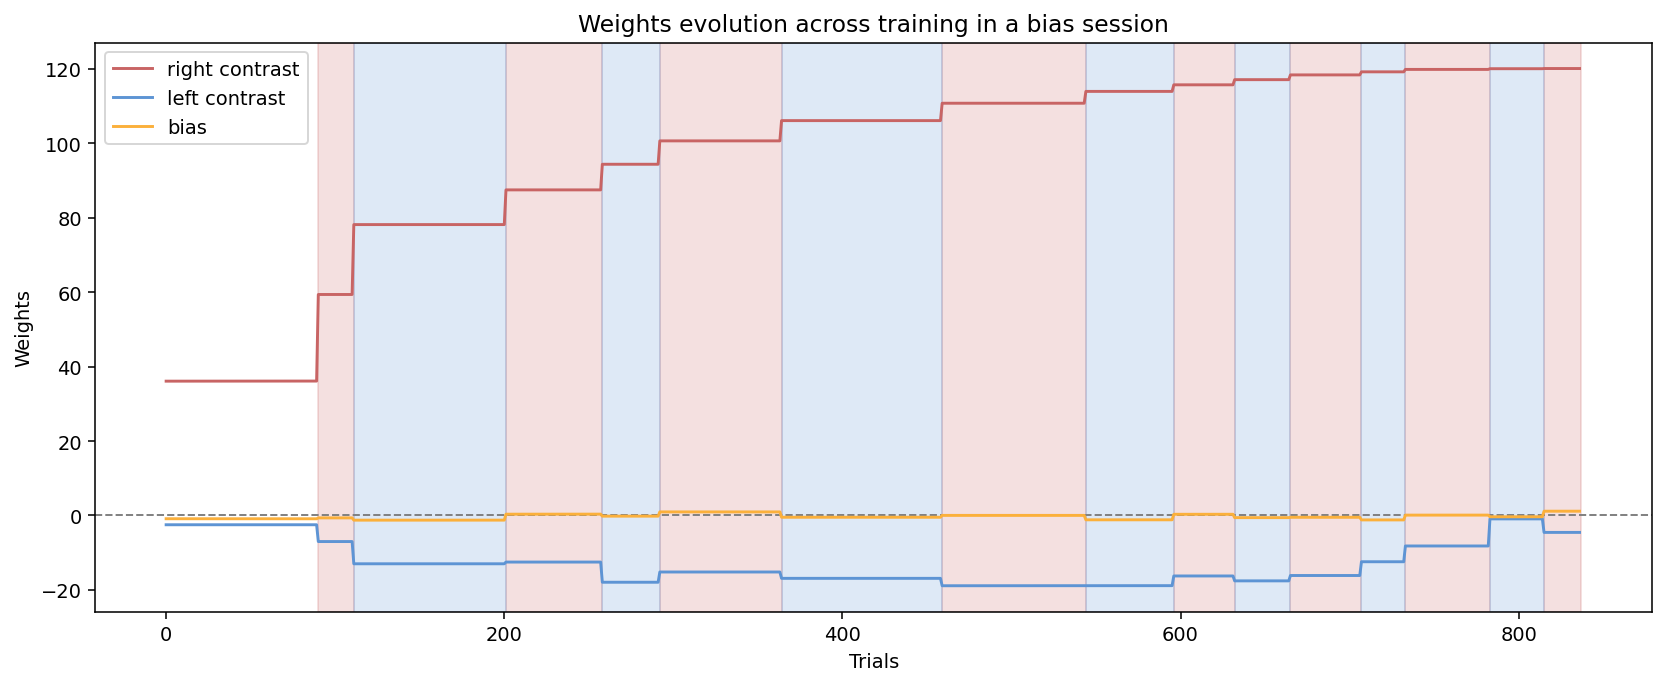

In [36]:
fig, ax = plot_bias_weight_evolution(df_m, wMode)

In [48]:
import seaborn as sns

def plot_all_subjects_training(df_train, figsize=(8, 5)):
    """
    fig 3d "Extracting the dynamics of behavior in sensory decision-making experiments Roy 2021"
    
    Plot right- and left-contrast weight trajectories across training
    for every subject in df_train.

    Parameters
    ----------
    df_train : pandas.DataFrame 
        The output of the PsyTrack all sessions works 
        Must contain only the training stage of the data.
        Must contain columns ['subject', 'session_num', 'left', 'right'].
    figsize : tuple, optional
        Figure size in inches.

    Returns
    -------
    ax : matplotlib.axes.Axes
        The Axes object of the plot.
    """
    # 1) sort and compute trial number within each subject
    df_train = df_train.reset_index()
    df = (df_train
          .sort_values(['subject', 'session_num', 'index'])
          .copy())
    df['trial_within_subject'] = df.groupby('subject').cumcount() + 1

    # 2) (optional) compute group‐level means if you need them
    left_mean = df.groupby('trial_within_subject')['left'].mean()
    right_mean = df.groupby('trial_within_subject')['right'].mean()
    bias_mean = df.groupby('trial_within_subject')['bias'].mean()

    # 3) plot each subject lightly
    plt.figure(figsize=figsize)
    for subj, subdf in df.groupby('subject'):
        sns.lineplot(
            data=subdf,
            x='trial_within_subject',
            y='right',
            color='#C86464',
            alpha=0.3,
            linewidth=0.8,
            legend=False
        )
        sns.lineplot(
            data=subdf,
            x='trial_within_subject',
            y='left',
            color='#5D94D4',
            alpha=0.3,
            linewidth=0.8,
            legend=False
        )
    sns.lineplot(data=right_mean, color='#C86464', alpha=0.9,label='right contrast')
    sns.lineplot(data=left_mean, color='#5D94D4', alpha=0.9, label='left contrast')
    # 4) zero line and labels
    plt.axhline(0, color='grey', linestyle='--', linewidth=1)
    plt.xlabel('Trials')
    plt.ylabel('Weights')
    plt.title('Training mice: contrast‐weight trajectories by subject')

    ax = plt.gca()
    return ax


In [49]:
df_train=pd.read_parquet('PSYTRACK_DAT.pqt')

In [50]:
df_train=df_train[df_train['stage']=='training']

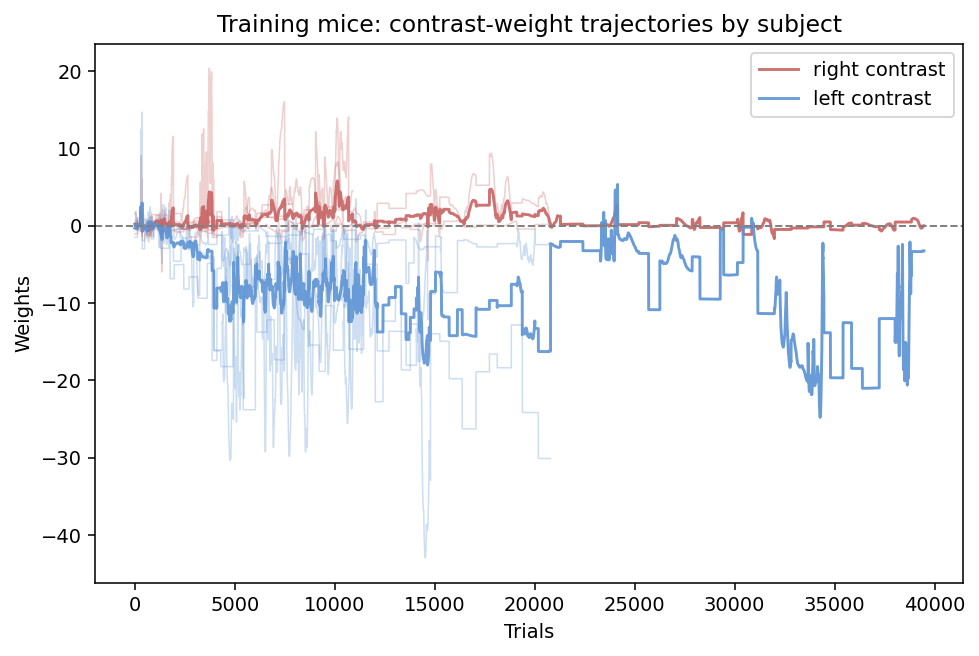

In [51]:
ax = plot_all_subjects_training(df_train)
plt.show()

In [ ]:
def plot_delta_bias_fig(b_df, n_sessions=5, figsize=(12, 4)):
    """
    fig 4d-e "Extracting the dynamics of behavior in sensory decision-making experiments Roy 2021"
    Plot Δ-bias across early vs late bias blocks in training.

    Parameters
    ----------
    b_df : pandas.DataFrame
        DataFrame containing at least the columns
        ['session_num', 'stage', 'probabilityLeft', 'bias'].
        'bias' ==> bias weight (the output of PsyTrack all sessions works)

    n_sessions : int, optional
        Number of sessions at the start and end to compare (default: 5).

    figsize : tuple, optional
        Size of the figure in inches (default: (12, 4)).

    Returns
    -------
    fig : matplotlib.figure.Figure
    axes : numpy.ndarray of Axes
    """
    # 1) Prepare the data
    df = b_df.copy()
    df['trial_in_session'] = df.groupby('session_num').cumcount() + 1

    # only bias‐stage trials
    bias_weights= df[df['stage'] == 'bias'].reset_index(drop=True)

    # select the trials that are biased
    bias_df = bias_weights[bias_weightsf['trial_in_session'] > 90]

    # sorted unique sessions
    sessions = np.sort(bias_df['session_num'].unique())
    first_sessions = sessions[:n_sessions]
    last_sessions  = sessions[-n_sessions:]

    # extract delta bias in blocks
    def extract_blocks(df_blocks):
        """
        Assign block_id by changes in probabilityLeft or session_num,
        then compute x, y, color tuples for each block.
        """
        d = df_blocks.copy()
        d['block_id'] = (
            (d['probabilityLeft'] != d['probabilityLeft'].shift()) |
            (d['session_num']    != d['session_num'].shift())
        ).cumsum()

        blocks = []
        for bid, grp in d.groupby('block_id'):
            if len(grp) < 2:
                continue
            x = np.arange(len(grp))
            y = grp['bias'].values - grp['bias'].values[0]
            color = '#C86464' if grp['probabilityLeft'].iloc[0] < 0.5 else '#5D94D4'
            blocks.append((x, y, color))
        return blocks

    early_blocks = extract_blocks(bias_df[bias_df['session_num'].isin(first_sessions)])
    late_blocks  = extract_blocks(bias_df[bias_df['session_num'].isin(last_sessions)])

    # 2) Plot side‐by‐side
    fig, axes = plt.subplots(1, 2, figsize=figsize, sharey=True)

    # Early blocks
    axes[0].set_title(f'Early Bias Blocks\n(first {n_sessions} sessions)')
    axes[0].set_xlabel('Trials from Start of Block')
    axes[0].set_ylabel(r'$\Delta$ bias weight')
    for x, y, c in early_blocks:
        axes[0].plot(x, y, color=c, alpha=1, linewidth=1)
    axes[0].axhline(0, color='k', linestyle='--', linewidth=1)

    # Late blocks
    axes[1].set_title(f'Late Bias Blocks\n(last {n_sessions} sessions)')
    axes[1].set_xlabel('Trials from Start of Block')
    for x, y, c in late_blocks:
        axes[1].plot(x, y, color=c, alpha=1, linewidth=1)
    axes[1].axhline(0, color='k', linestyle='--', linewidth=1)

    plt.tight_layout()
    return fig, axes